In [1]:
import pypose as pp
from pypose.optim import LM, ALA, Unconstrained_Model
from pypose.optim import Generalized_SGD
from mpl_toolkits.mplot3d import Axes3D
from pypose.optim.strategy import Constant
from pypose.optim.scheduler import StopOnPlateau
from pypose.optim.solver import Cholesky
from pypose.lietensor import randn_SE3
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from torch import nn
import torch
import pypose
from LQR_solver import *


torch.manual_seed(0)

### Define the test sample, tau_gt and mu_gt

### Define Objective Function in Objective Net, Constraints in ConstrainNet

In [2]:
### Define Objective Model whose Parameters to be Minimzed 
class InvNet(nn.Module):
    
    def __init__(self, *dim):
        super().__init__()
        init = pp.randn_so3(*dim)
        
        self.pose = pp.Parameter(init)

    def forward(self, input):
        error = (self.pose @ input)
        return error.tensor()


### Define Constraits Model, inhereted from objective model to create C(\theta)
class ConstrainNet(nn.Module):
    
    def __init__(self, objective_net):
        super().__init__()
        
        self.net = objective_net
        
    def forward(self, input):
        constraint_violation = self.net.pose - 20*torch.ones_like(input)
        return constraint_violation

### Prepare objective net 'InvNet', constraints 'ConstrainNet', and input

In [3]:

device = torch.device("cuda:6")
input = pp.randn_so3(2, device=device)
### instantiated objective and consntraints
invnet = InvNet(2, 2).to(device)
### Feed the params to constraints to obtain C(\theta)
constraints = ConstrainNet(invnet).to(device)
strategy = Constant(damping=1e-4)

In [4]:
import matplotlib.pyplot as plt

losses = [] 
constraint_violation = []
objective_loss = []

### Setting ALA optimizer, 
optimizer = ALA(model=invnet, constraints=constraints, penalty_factor=50, num_iter=20)
scheduler = StopOnPlateau(optimizer, steps=20, patience=10, decreasing=1e-3, verbose=True)

# 2nd option, step optimization
while scheduler.continual():
    loss = optimizer.step(input)
    scheduler.step(loss)
    losses.append(torch.norm(loss).cpu().detach().numpy())
    constraint_violation.append(torch.norm(constraints(input)).cpu().detach().numpy())
    objective_loss.append(torch.norm(invnet(input)).cpu().detach().numpy())


tensor(37.6103, device='cuda:6') tensor(15.9773, device='cuda:6')
StopOnPlateau on step 0 Loss 7.249257e+10 --> Loss 6.002792e+10 (reduction/loss: 1.7194e-01).
tensor(37.5936, device='cuda:6') tensor(15.9706, device='cuda:6')
StopOnPlateau on step 1 Loss 6.002792e+10 --> Loss 7.104353e+10 (reduction/loss: -1.8351e-01).
tensor(27.4340, device='cuda:6') tensor(14.2361, device='cuda:6')
StopOnPlateau on step 2 Loss 7.104353e+10 --> Loss 2.621355e+10 (reduction/loss: 6.3102e-01).
tensor(22.2661, device='cuda:6') tensor(13.4654, device='cuda:6')
StopOnPlateau on step 3 Loss 2.621355e+10 --> Loss 1.654572e+10 (reduction/loss: 3.6881e-01).
tensor(19.9484, device='cuda:6') tensor(13.8182, device='cuda:6')
StopOnPlateau on step 4 Loss 1.654572e+10 --> Loss 1.533394e+10 (reduction/loss: 7.3238e-02).
tensor(18.0228, device='cuda:6') tensor(14.1802, device='cuda:6')
StopOnPlateau on step 5 Loss 1.533394e+10 --> Loss 1.410036e+10 (reduction/loss: 8.0447e-02).
tensor(14.0825, device='cuda:6') tensor

### Return optimized (mu -> returned L_multiplier) and (tau -> optimized model parameters)


In [8]:
mu_star = optimizer.aga_model.lmd
tau_star = invnet.pose

print(f"optimized_mu: \nvalue: {mu_star}, \n\noptimized_tau: \nvalue: {tau_star}")

optimized_mu: 
value: tensor([[[-1061.4089,  -982.9936,  -211.0019],
         [  226.3225,   731.2206,   699.2915]],

        [[ 6694.8081, -1202.0994,  -817.8990],
         [  475.2666,  -685.2205, -3956.8535]]], device='cuda:6'), 

optimized_tau: 
value: so3Type Parameter:
Parameter containing:
Parameter(Parameter([[[19.9989, 19.9995, 19.9841],
            [20.0115, 19.9970, 19.9850]],

           [[20.0002, 19.9996, 19.9959],
            [20.0055, 20.0032, 20.0027]]], device='cuda:6', requires_grad=True))


### Calculate the error compared with GT

### Draw loss curve for both AGA_Loss, Cnstraint_Violation and Objective_Loss, check convergence

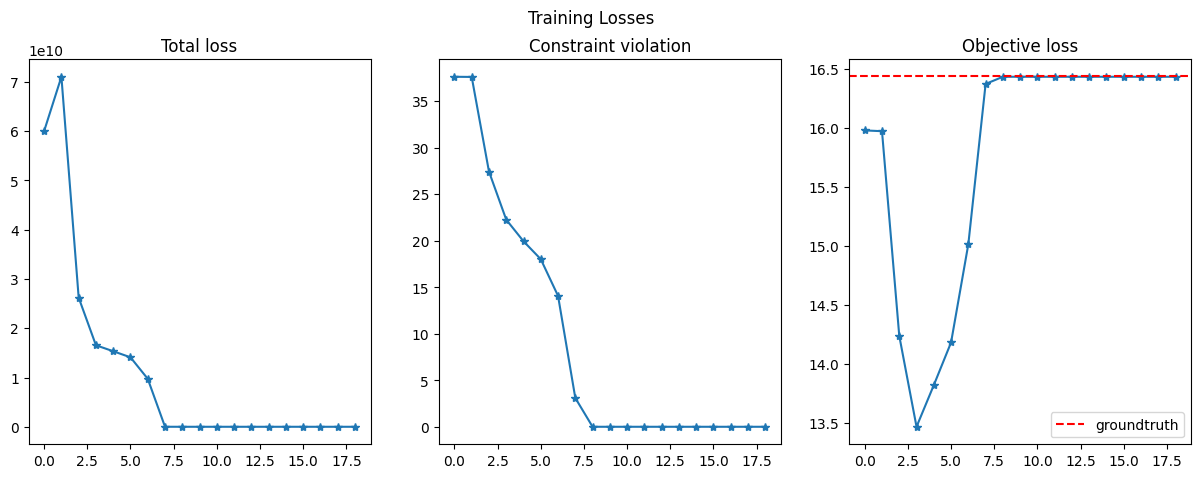

In [9]:
import matplotlib.pyplot as plt

# Define the figure and subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot the first line on the first subplot
axs[0].plot(losses, '*-')
axs[0].set_title('Total loss')

# Plot the second line on the second subplot
axs[1].plot(constraint_violation, '*-')
axs[1].set_title('Constraint violation')

# Plot the third line on the third subplot
axs[2].plot(objective_loss, '*-')
axs[2].set_title('Objective loss')
# Add horizontal line at y=10 on third subplot
axs[2].axhline(y=torch.norm(input * torch.ones_like(tau_star).to(input.device) * 20).detach().cpu(), linestyle='--', color='r', label='groundtruth')
# Add legend to third subplot
axs[2].legend()

# Set common y-axis label and show the figure
fig.suptitle('Training Losses')
plt.show()
